In [1]:
import pandas as pd
import openpyxl
import statsmodels.api as sm
import matplotlib.pylab as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose



from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from sklearn.metrics import mean_squared_error
import itertools


%matplotlib inline

In [51]:
base_ventas = pd.read_excel(r"/home/serway_85/ventasParasoles (2) (2).xlsm",sheet_name='ventas',index_col='Mes')
#base_ventas = pd.read_excel(r"C:\Users\JORGE CONTRERAS\OneDrive - 900208659-2 DAMIS SAS\Escritorio\PLANEACION\consumos\INDICADORES PLANEACION\ventasParasoles.xlsm",sheet_name='ventas',index_col='Mes')

base_analisis_pergolite=base_ventas[(base_ventas['Familia']=='PERGOLITE') & (base_ventas['Tipo Factu']=='PRODUCTO TERMINADO')]




base_analisis_pergolite=base_analisis_pergolite[['Cantidad']]

base_analisis_pergolite=base_analisis_pergolite.groupby(['Mes'])['Cantidad'].sum().reset_index()
base_analisis_pergolite = base_analisis_pergolite.sort_values('Mes')



#print(base_analisis_pergolite)
base_analisis_pergolite.to_excel('base_prueba2.xlsx')


#print(base_analisis_pergolite[['Mes','Cantidad']].head())  # Revisa si 'Mes' tiene valores NaT



#print(base_analisis_pergolite)

 # Usa el último valor conocido
base_analisis_pergolite['Mes'] = base_analisis_pergolite['Mes'].dt.to_period('M').dt.to_timestamp()
base_analisis_pergolite['Mes'] = pd.to_datetime(base_analisis_pergolite['Mes'], format='%b-%y')
base_analisis_pergolite.set_index('Mes',inplace = True)
base_analisis_pergolite=base_analisis_pergolite.asfreq('MS').interpolate()









print(base_analisis_pergolite.columns)


base_analisis_pergolite.to_excel('base_prueba.xlsx')

base_analisis_pergolite_com = base_analisis_pergolite.copy()
print(base_analisis_pergolite_com)




Index(['Cantidad'], dtype='object')
             Cantidad
Mes                  
2020-01-01   3.000000
2020-02-01   8.000000
2020-03-01   1.000000
2020-04-01   3.333333
2020-05-01   5.666667
2020-06-01   8.000000
2020-07-01  10.000000
2020-08-01   3.000000
2020-09-01   8.000000
2020-10-01  16.000000
2020-11-01   9.000000
2020-12-01   3.000000
2021-01-01   1.000000
2021-02-01   5.000000
2021-03-01   3.000000
2021-04-01   1.000000
2021-05-01   5.000000
2021-06-01   9.000000
2021-07-01  11.000000
2021-08-01   7.000000
2021-09-01   3.000000
2021-10-01   4.000000
2021-11-01   4.000000
2021-12-01   4.000000
2022-01-01   4.000000
2022-02-01   9.000000
2022-03-01   1.000000
2022-04-01   1.000000
2022-05-01  10.000000
2022-06-01   4.000000
2022-07-01   5.000000
2022-08-01   4.000000
2022-09-01  11.000000
2022-10-01   5.000000
2022-11-01   8.000000
2022-12-01   3.000000
2023-01-01   3.000000
2023-02-01   8.000000
2023-03-01  15.000000
2023-04-01   2.000000
2023-05-01  10.000000
2023-06-01   6.000

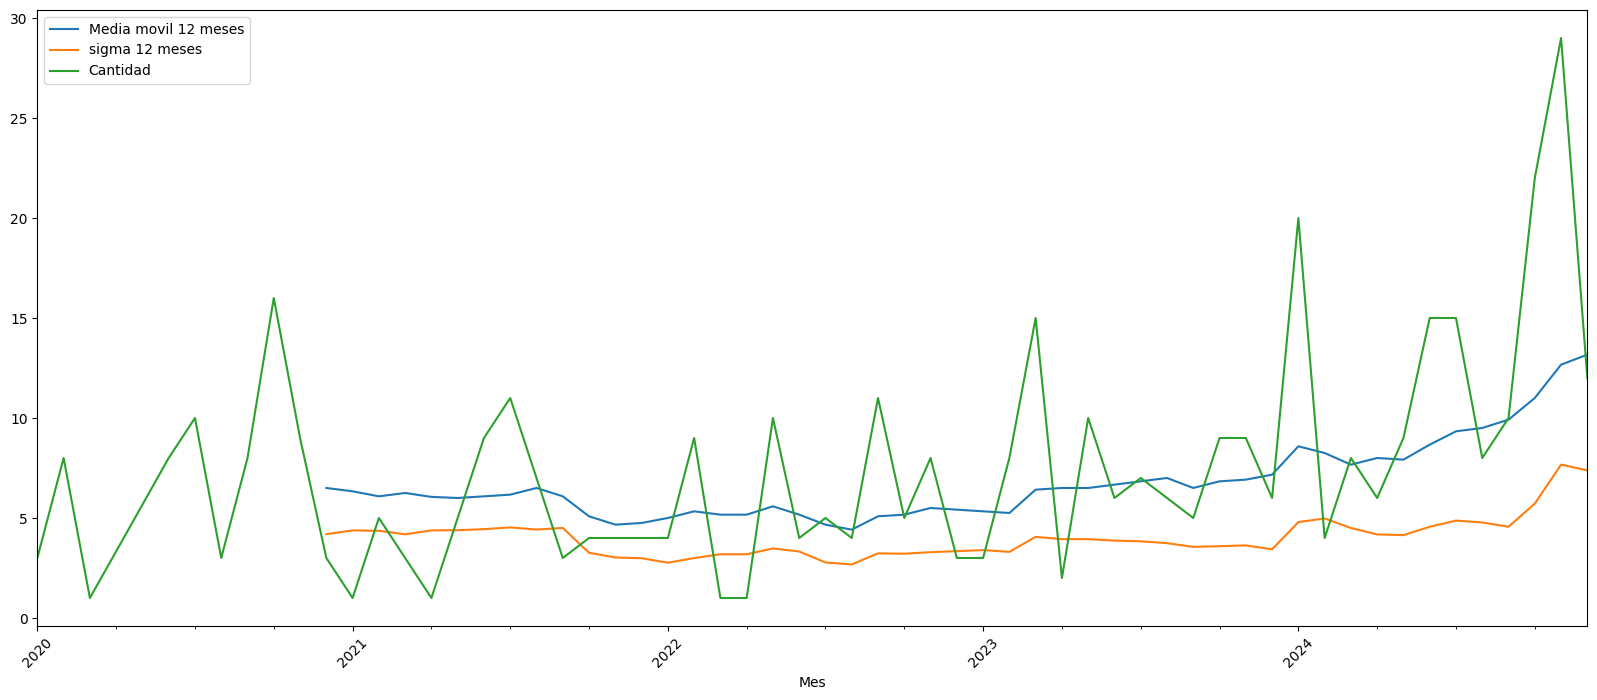

In [52]:
serietiempo = base_analisis_pergolite['Cantidad']
type(serietiempo)
plt.figure(figsize=(20,8))
serietiempo.rolling(12).mean().plot(label= 'Media movil 12 meses')
serietiempo.rolling(12).std().plot(label= 'sigma 12 meses')
serietiempo.plot()
plt.xticks(rotation=45)  # Rotar los meses para que sean legibles
#plt.xticks(ticks=range(len(base_analisis_pergolite.index)), labels=base_analisis_pergolite.index) 

plt.legend()


DESCOMPOSICION ESTACIONAL

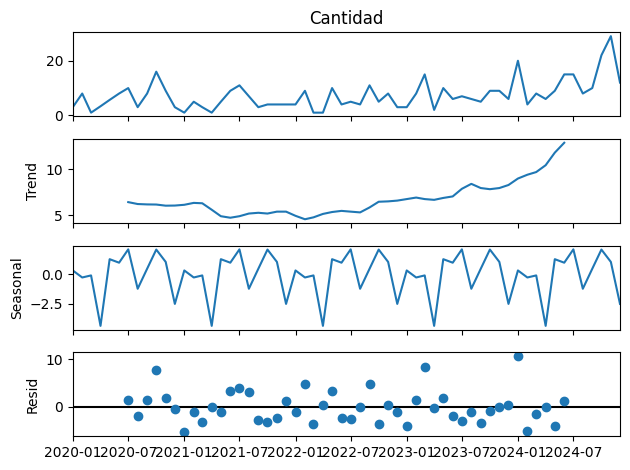

In [53]:
#decomposition = seasonal_decompose(base_analisis_pergolite['Cantidad'], model='additive')
#decomposition.plot()
#plt.show()

decompositionu = seasonal_decompose(base_analisis_pergolite['Cantidad'], model='additive')
decompositionu.plot()
plt.show()

In [5]:
#prueba de dickey-fuller aumentada

In [54]:
from statsmodels.tsa.stattools import adfuller

In [55]:
resultado = adfuller(base_analisis_pergolite['Cantidad'])

resultado


(np.float64(2.178398242190711),
 np.float64(0.9988642555681293),
 9,
 50,
 {'1%': np.float64(-3.568485864),
  '5%': np.float64(-2.92135992),
  '10%': np.float64(-2.5986616)},
 np.float64(293.22109620664384))

DESCOMPOSICION DE LA SERIE


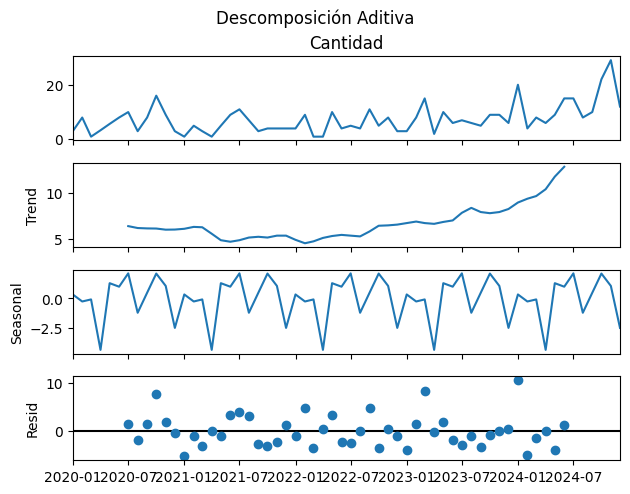

In [56]:

# Suponiendo que tu data es mensual con posible estacionalidad de 12 meses
model = ExponentialSmoothing(
    base_analisis_pergolite['Cantidad'], 
    trend='add',          # tendencia aditiva
    seasonal='add',       # estacionalidad aditiva
    seasonal_periods=12   # 12 meses
)
fit = model.fit()

n_test = len(base_analisis_pergolite['Cantidad'])
hw_forecast = fit.forecast(steps=n_test)
hw_forecast

# 1. Descomposición aditiva
result_add = seasonal_decompose(base_analisis_pergolite['Cantidad'], model='additive', period=12)
fig_add = result_add.plot()
fig_add.suptitle('Descomposición Aditiva', y=1.02)
plt.show()




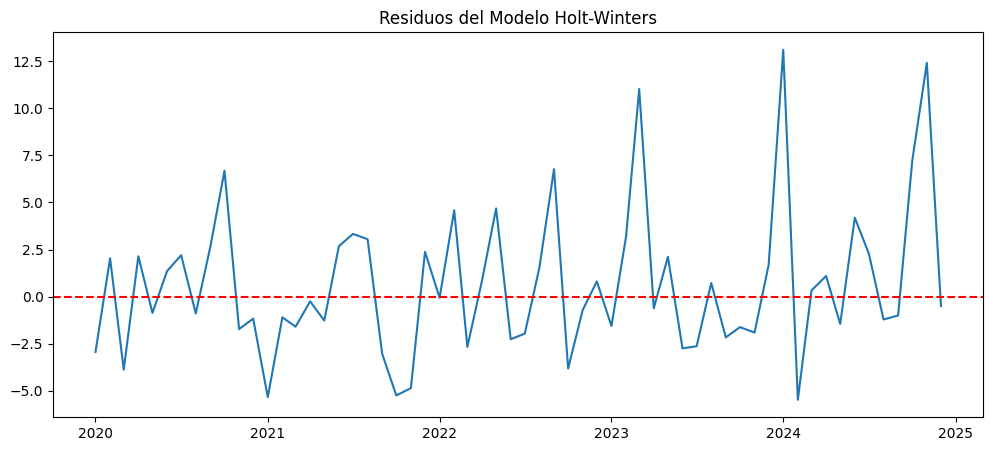

Estadístico de prueba: 33.3948
p-valor: 0.0002
❌ Hay evidencia de heterocedasticidad (varianza no constante).


In [57]:
# Calcular los residuos
residuos_hw = base_analisis_pergolite['Cantidad'] - fit.fittedvalues

# Graficar los residuos
plt.figure(figsize=(12, 5))
plt.plot(residuos_hw)
plt.title("Residuos del Modelo Holt-Winters")
plt.axhline(y=0, color='red', linestyle='--')
plt.show()

from statsmodels.stats.diagnostic import het_arch

# Realiza la prueba ARCH
arch_test = het_arch(residuos_hw)

# Resultados
print(f"Estadístico de prueba: {arch_test[0]:.4f}")
print(f"p-valor: {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("❌ Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("✅ No hay evidencia de heterocedasticidad (varianza constante).")


In [58]:
base_analisis_pergolite=np.log(base_analisis_pergolite['Cantidad'])
base_analisis_pergolite_v2=base_analisis_pergolite.copy()


In [12]:
print(base_analisis_pergolite_v2)
base_analisis_pergolite_v2.to_excel('baseTT.xlsx')

Mes
2020-01-01    1.098612
2020-02-01    2.079442
2020-03-01    0.000000
2020-04-01    1.203973
2020-05-01    1.734601
2020-06-01    2.079442
2020-07-01    2.302585
2020-08-01    1.098612
2020-09-01    2.079442
2020-10-01    2.772589
2020-11-01    2.197225
2020-12-01    1.098612
2021-01-01    0.000000
2021-02-01    1.609438
2021-03-01    1.098612
2021-04-01    0.000000
2021-05-01    1.609438
2021-06-01    2.197225
2021-07-01    2.397895
2021-08-01    1.945910
2021-09-01    1.098612
2021-10-01    1.386294
2021-11-01    1.386294
2021-12-01    1.386294
2022-01-01    1.386294
2022-02-01    2.197225
2022-03-01    0.000000
2022-04-01    0.000000
2022-05-01    2.302585
2022-06-01    1.386294
2022-07-01    1.609438
2022-08-01    1.386294
2022-09-01    2.397895
2022-10-01    1.609438
2022-11-01    2.079442
2022-12-01    1.098612
2023-01-01    1.098612
2023-02-01    2.079442
2023-03-01    2.708050
2023-04-01    0.693147
2023-05-01    2.302585
2023-06-01    1.791759
2023-07-01    1.945910
2023-08

In [60]:

train_size = int(len(base_analisis_pergolite_com) * 0.8)
train, test = base_analisis_pergolite_com[:train_size], base_analisis_pergolite_com[train_size:]

'''
train_size = int(len(base_analisis_pergolite_v2) * 0.7)
print(train_size)

train = base_analisis_pergolite_v2.iloc[:train_size]
test = base_analisis_pergolite_v2.iloc[train_size:]



'''



print(f"Entrenamiento: {len(train)} observaciones")
print(f"Prueba: {len(test)} observaciones")



BaseA = base_analisis_pergolite_v2[:42
                      ]
BaseB = base_analisis_pergolite_v2[42:]
BaseA.to_excel('BaseA.xlsx')
BaseB.to_excel('BaseB.xlsx')
train

Entrenamiento: 48 observaciones
Prueba: 12 observaciones


,Cantidad
Mes,
2020-01-01,3.000000
2020-02-01,8.000000
2020-03-01,1.000000
2020-04-01,3.333333
2020-05-01,5.666667
2020-06-01,8.000000
2020-07-01,10.000000
2020-08-01,3.000000
2020-09-01,8.000000


/tmp/ipykernel_40217/1555808215.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(base_analisis_pergolite_com.index[-1], periods=future_steps + 1, freq='M')[1:]


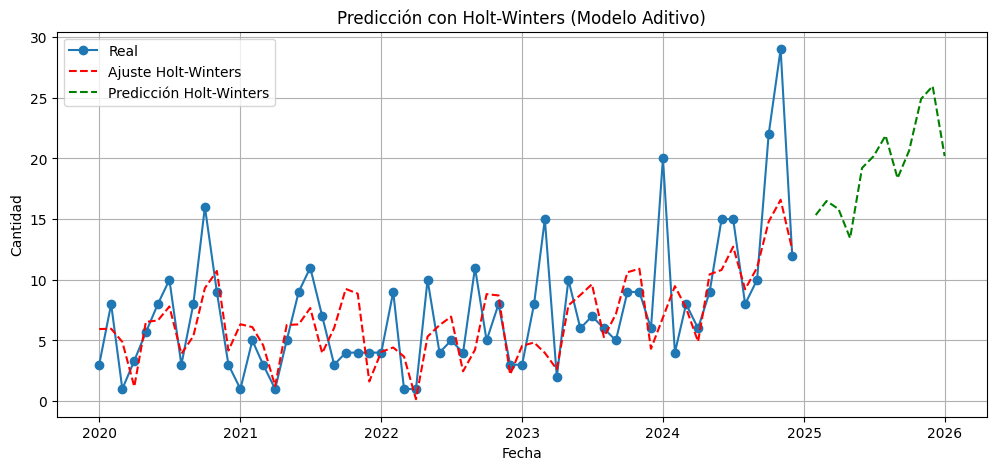

            Predicción
Mes                   
2025-01-31   15.336356
2025-02-28   16.489375
2025-03-31   15.831890
2025-04-30   13.428436
2025-05-31   19.214137
2025-06-30   20.188583
2025-07-31   21.885443
2025-08-31   18.370174
2025-09-30   20.643307
2025-10-31   24.905451
2025-11-30   25.956637
2025-12-31   20.195760


In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Cargar datos desde el archivo Excel


# Aplicar el modelo de Holt-Winters con componentes aditivos
model = ExponentialSmoothing(base_analisis_pergolite_com["Cantidad"], trend="add", seasonal="add", seasonal_periods=12)
fit = model.fit()

# Hacer predicciones para los próximos 12 meses
future_steps = 12
future_dates = pd.date_range(base_analisis_pergolite_com.index[-1], periods=future_steps + 1, freq='M')[1:]
forecast = fit.forecast(steps=future_steps)

# Crear un DataFrame para las predicciones futuras
forecast_df = pd.DataFrame({"Mes": future_dates, "Predicción": forecast}).set_index("Mes")

# Graficar los datos reales y las predicciones
plt.figure(figsize=(12, 5))
plt.plot(base_analisis_pergolite_com["Cantidad"], label="Real", marker='o', linestyle='-')
plt.plot(fit.fittedvalues, label="Ajuste Holt-Winters", linestyle='dashed', color='red')
plt.plot(forecast_df["Predicción"], label="Predicción Holt-Winters", linestyle='dashed', color='green')
plt.xlabel("Fecha")
plt.ylabel("Cantidad")
plt.title("Predicción con Holt-Winters (Modelo Aditivo)")
plt.legend()
plt.grid()
plt.show()

# Mostrar las predicciones
print(forecast_df)


In [71]:
print(test)

            Cantidad
Mes                 
2024-01-01      20.0
2024-02-01       4.0
2024-03-01       8.0
2024-04-01       6.0
2024-05-01       9.0
2024-06-01      15.0
2024-07-01      15.0
2024-08-01       8.0
2024-09-01      10.0
2024-10-01      22.0
2024-11-01      29.0
2024-12-01      12.0


metodo para encontrar los mejores parametros de pdq


In [ ]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Simulación de una serie temporal (o usa tus datos)
np.random.seed(42)
data = np.cumsum(np.random.randn(100))  # Serie de prueba

# Definir los rangos de valores a probar
p_values = range(0, 7)   # Valores de p (AR)
d_values = range(0, 2)   # Valores de d (Diferenciación)
q_values = range(0, 7)   # Valores de q (MA)

P_values = range(0, 7)   # Valores de P (AR estacional)
D_values = range(0, 2)   # Valores de D (Diferenciación estacional)
Q_values = range(0, 7)   # Valores de Q (MA estacional)
s_values = [12]          # Valores de estacionalidad (s = 12 si datos mensuales)

# Generar todas las combinaciones de parámetros
param_combinations = list(itertools.product(p_values, d_values, q_values))
seasonal_combinations = list(itertools.product(P_values, D_values, Q_values, s_values))

# Variables para almacenar el mejor modelo
best_aic = np.inf
best_order = None
best_seasonal_order = None
best_model = None

# Bucle para probar cada combinación de (p,d,q) y (P,D,Q,s)
for order in param_combinations:
    for seasonal_order in seasonal_combinations:
        try:
            model = sm.tsa.SARIMAX(train, order=order, seasonal_order=seasonal_order, 
                                   enforce_stationarity=False, enforce_invertibility=False).fit()
            aic = model.aic  # Obtener el AIC del modelo
            print(f"SARIMA{order}x{seasonal_order} - AIC: {aic}")

            # Guardar el mejor modelo
            if aic < best_aic:
                best_aic = aic
                best_order = order
                best_seasonal_order = seasonal_order
                best_model = model
        except:
            continue  # Si un modelo falla, lo omitimos

print("\nMejor modelo SARIMA encontrado:")
print(f"Orden (p,d,q): {best_order}")
print(f"Orden estacional (P,D,Q,s): {best_seasonal_order}")
print(f"Mejor AIC: {best_aic}")



SARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC: 187.3646451682509
SARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC: 1482.1781986113872


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(0, 0, 2, 12) - AIC: 84.93896518121952
SARIMA(0, 0, 0)x(0, 0, 3, 12) - AIC: 54.23947620288688
SARIMA(0, 0, 0)x(0, 0, 4, 12) - AIC: 10.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(0, 0, 5, 12) - AIC: 12.0
SARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC: 89.43778086662813
SARIMA(0, 0, 0)x(0, 1, 1, 12) - AIC: 50.49355079008188


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(0, 1, 2, 12) - AIC: 30.1731664751466
SARIMA(0, 0, 0)x(0, 1, 3, 12) - AIC: 8.0
SARIMA(0, 0, 0)x(0, 1, 4, 12) - AIC: 10.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(0, 1, 5, 12) - AIC: 12.0
SARIMA(0, 0, 0)x(0, 1, 6, 12) - AIC: 14.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC: 93.1032380750529
SARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC: 1545.3225759130364


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC: 58.007358502083655
SARIMA(0, 0, 0)x(1, 0, 3, 12) - AIC: 39.788283832995205


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 0, 4, 12) - AIC: 12.0
SARIMA(0, 0, 0)x(1, 0, 5, 12) - AIC: 14.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 0, 6, 12) - AIC: 16.0
SARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC: 50.895067337353936
SARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC: 50.56933677156426
SARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC: 31.546489012639984


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-p

SARIMA(0, 0, 0)x(1, 1, 3, 12) - AIC: 10.0
SARIMA(0, 0, 0)x(1, 1, 4, 12) - AIC: 12.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 1, 5, 12) - AIC: 14.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(1, 1, 6, 12) - AIC: 16.0
SARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC: 52.55985650052942


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC: 833.6880838803343
SARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC: 53.390887009293685
SARIMA(0, 0, 0)x(2, 0, 3, 12) - AIC: 34.08261261342513
SARIMA(0, 0, 0)x(2, 0, 4, 12) - AIC: 14.0
SARIMA(0, 0, 0)x(2, 0, 5, 12) - AIC: 16.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(2, 0, 6, 12) - AIC: 18.0
SARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC: 31.751852596619777
SARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC: 33.751863958617776


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC: 33.5465000912468
SARIMA(0, 0, 0)x(2, 1, 3, 12) - AIC: 12.0
SARIMA(0, 0, 0)x(2, 1, 4, 12) - AIC: 14.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(2, 1, 5, 12) - AIC: 16.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(2, 1, 6, 12) - AIC: 18.0
SARIMA(0, 0, 0)x(3, 0, 0, 12) - AIC: 31.981387346899623


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA(0, 0, 0)x(3, 0, 1, 12) - AIC: 367.1828431553861
SARIMA(0, 0, 0)x(3, 0, 2, 12) - AIC: 35.9813873561373
SARIMA(0, 0, 0)x(3, 0, 3, 12) - AIC: 35.922269861187274
SARIMA(0, 0, 0)x(3, 0, 4, 12) - AIC: 16.0
SARIMA(0, 0, 0)x(3, 0, 5, 12) - AIC: 18.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2024-01-01    -0.163773
2024-02-01     4.979005
2024-03-01     7.486006
2024-04-01     3.807186
2024-05-01     8.787174
2024-06-01     9.169121
2024-07-01    10.854006
2024-08-01     7.687137
2024-09-01     5.968651
2024-10-01     8.737056
2024-11-01     7.897477
2024-12-01     6.419547
Freq: MS, Name: predicted_mean, dtype: float64
MSE (Error Cuadrático Medio): 94.38
MAE (Error Absoluto Medio): 6.53
RMSE (Raíz del Error Cuadrático Medio): 9.71


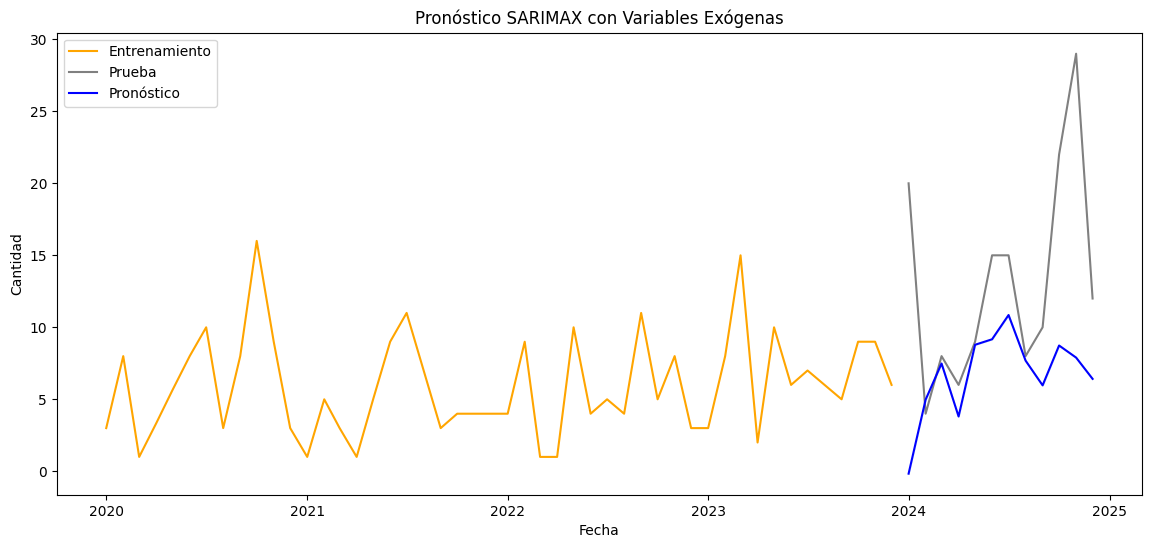

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# ===========================
# 📆 2. Preparar Datos
# ===========================
# Crear variables exógenas (Dummies para meses clave)
base_analisis_pergolite_com['may_jun'] = base_analisis_pergolite_com.index.month.isin([5, 6]).astype(int)
base_analisis_pergolite_com['oct'] = (base_analisis_pergolite_com.index.month == 10).astype(int)
base_analisis_pergolite_com['dic'] = (base_analisis_pergolite_com.index.month == 12).astype(int)
base_analisis_pergolite_com['ene'] = (base_analisis_pergolite_com.index.month == 12).astype(int)

# Definir variable objetivo y exógenas
y = base_analisis_pergolite_com['Cantidad']
exog = base_analisis_pergolite_com[['may_jun', 'oct', 'dic','ene']]

# Dividir en conjunto de entrenamiento y prueba (80% / 20%)
train_size = int(len(base_analisis_pergolite_com) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]
exog_train, exog_test = exog[:train_size], exog[train_size:]

# ===========================
# 🤖 3. Ajustar Modelo SARIMAX
# ===========================
# Ajustar modelo SARIMAX con parámetros iniciales
model_exog = SARIMAX(y_train, exog=exog_train, order=(2,1,7), seasonal_order=(2,1,2,12),enforce_stationarity=False,
                          enforce_invertibility=False)
result_exog = model_exog.fit()

# ===========================
# 📊 4. Generar Pronóstico
# ===========================
forecast = result_exog.get_forecast(steps=len(y_test), exog=exog_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
print(forecast_mean)

# ===========================
# 📏 5. Evaluar Modelo
# ===========================
mse = mean_squared_error(y_test, forecast_mean)
mae = mean_absolute_error(y_test, forecast_mean)
rmse = np.sqrt(mse)

print(f'MSE (Error Cuadrático Medio): {mse:.2f}')
print(f'MAE (Error Absoluto Medio): {mae:.2f}')
print(f'RMSE (Raíz del Error Cuadrático Medio): {rmse:.2f}')

# ===========================
# 📈 6. Graficar Resultados
# ===========================
plt.figure(figsize=(14,6))
plt.plot(y_train, label='Entrenamiento', color='orange')
plt.plot(y_test, label='Prueba', color='gray')
plt.plot(forecast_mean, label='Pronóstico', color='blue')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='lightblue', alpha=0.3)
plt.title('Pronóstico SARIMAX con Variables Exógenas')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.show()

In [11]:
p = d = q = range(0, 3)  # Ordenes AR, I y MA
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] 

In [12]:
best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

In [13]:
for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            mod = SARIMAX(y_train,
                          order=param,
                          seasonal_order=seasonal_param,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit(disp=False)

            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_seasonal_order = seasonal_param
                best_model = results
        except:
            continue

print(f"Mejores parámetros encontrados:")
print(f"Orden SARIMA: {best_order}")
print(f"Orden estacional: {best_seasonal_order}")
print(f"AIC: {best_aic}")

/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-p

Mejores parámetros encontrados:
Orden SARIMA: (0, 0, 0)
Orden estacional: (0, 2, 2, 12)
AIC: 6.0


In [22]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=9)

for train_index, test_index in tscv.split(y):
    y_train, y_test = y[train_index], y[test_index]
    
    mod = SARIMAX(y_train,
                  order=best_order,
                  seasonal_order=best_seasonal_order,
                  enforce_stationarity=False,
                  enforce_invertibility=False)
    
    results = mod.fit(disp=False)
    forecast = results.get_forecast(steps=len(y_test))
    forecast_mean = forecast.predicted_mean

    rmse = np.sqrt(mean_squared_error(y_test, forecast_mean))
    print(f"RMSE en iteración: {rmse:.2f}")


/tmp/ipykernel_32877/3837145678.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/tmp/ipykernel_32877/3837145678.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/home/serway_85/proyecto_pro

RMSE en iteración: 9.30
RMSE en iteración: 4.94
RMSE en iteración: 11.39
RMSE en iteración: 5.22
RMSE en iteración: 9.32
RMSE en iteración: 7.87
RMSE en iteración: 7.29
RMSE en iteración: 11.78


/tmp/ipykernel_32877/3837145678.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/tmp/ipykernel_32877/3837145678.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train, y_test = y[train_index], y[test_index]
/home/serway_85/proyecto_pro

RMSE en iteración: 12.66


Promedio del RMSE: 8.39
Desviación estándar del RMSE: 2.39
Mejor RMSE (menor error): 4.94


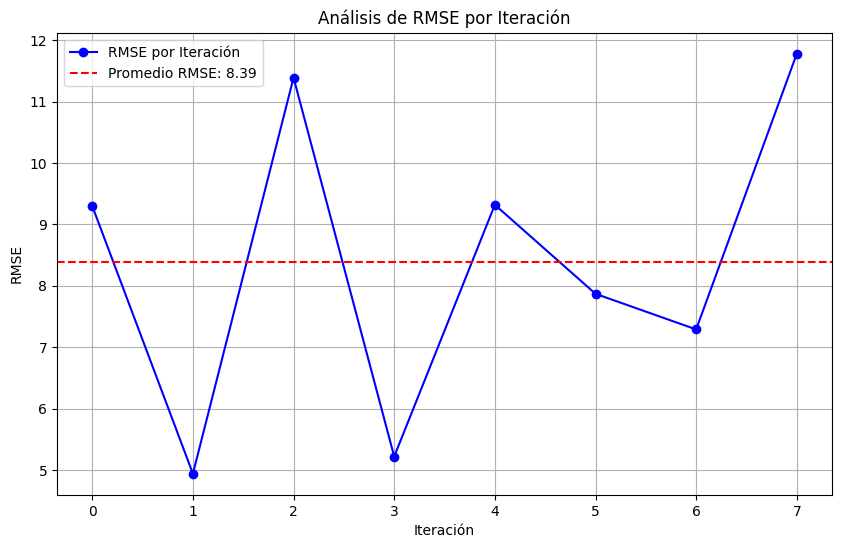

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# RMSE de cada iteración
rmse_values = [9.30, 4.94, 11.39, 5.22, 9.32, 7.87, 7.29, 11.78]

# Cálculos
promedio = np.mean(rmse_values)
desviacion = np.std(rmse_values)
mejor_iteracion = np.min(rmse_values)

# Resultados
print(f"Promedio del RMSE: {promedio:.2f}")
print(f"Desviación estándar del RMSE: {desviacion:.2f}")
print(f"Mejor RMSE (menor error): {mejor_iteracion:.2f}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(rmse_values, marker='o', color='b', label='RMSE por Iteración')
plt.axhline(promedio, color='r', linestyle='--', label=f'Promedio RMSE: {promedio:.2f}')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.title('Análisis de RMSE por Iteración')
plt.legend()
plt.grid(True)
plt.show()


Promedio del RMSE: 8.39
Desviación estándar del RMSE: 2.25
Mejor RMSE (menor error): 4.94
Outliers detectados: []


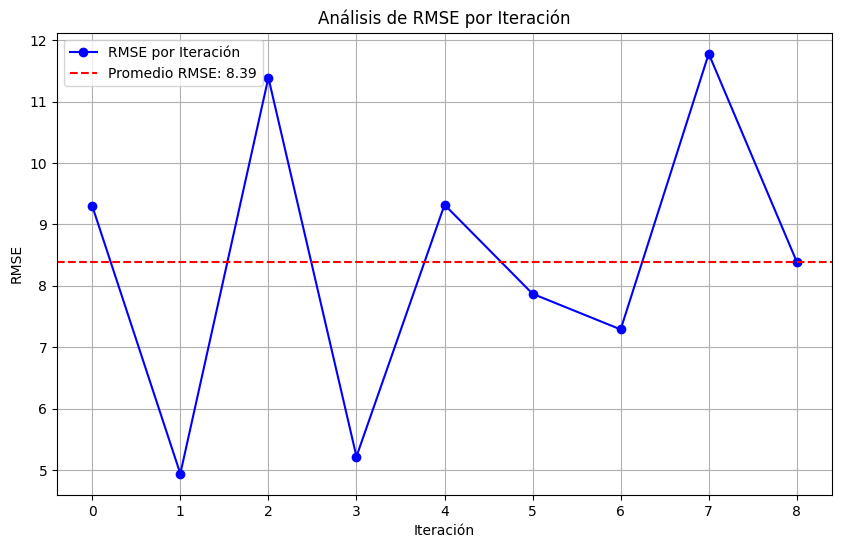

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# RMSE de cada iteración
rmse_values = [9.30, 4.94, 11.39, 5.22, 9.32, 7.87, 7.29, 11.78, 8.39]

# Cálculos
promedio = np.mean(rmse_values)
desviacion = np.std(rmse_values)
mejor_iteracion = np.min(rmse_values)
outliers = [x for x in rmse_values if x > promedio + 2 * desviacion]

# Resultados
print(f"Promedio del RMSE: {promedio:.2f}")
print(f"Desviación estándar del RMSE: {desviacion:.2f}")
print(f"Mejor RMSE (menor error): {mejor_iteracion:.2f}")
print(f"Outliers detectados: {outliers}")

# Gráfico
plt.figure(figsize=(10, 6))
plt.plot(rmse_values, marker='o', color='b', label='RMSE por Iteración')
plt.axhline(promedio, color='r', linestyle='--', label=f'Promedio RMSE: {promedio:.2f}')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.title('Análisis de RMSE por Iteración')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
optimal_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
optimal_results = optimal_model.fit()

print(optimal_results.summary())



/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                           Cantidad   No. Observations:                   48
Model:             SARIMAX(1, 1, 2)x(2, 1, 2, 12)   Log Likelihood                   6.347
Date:                            Mon, 24 Feb 2025   AIC                              3.305
Time:                                    04:51:20   BIC                              3.941
Sample:                                01-01-2020   HQIC                            -0.981
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2306      0.609      0.379      0.705      -0.963       1.424
ma.L1          0.4228     17.338   

/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [77]:

optimal_model_two = SARIMAX(train, order=(0,1,0), seasonal_order=(1,1,0,12),
                        enforce_stationarity=False, enforce_invertibility=False)
optimal_results_two = optimal_model_two.fit()

print(optimal_results_two.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Cantidad   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -27.008
Date:                            Mon, 24 Feb 2025   AIC                             58.016
Time:                                    05:01:45   BIC                             60.287
Sample:                                01-01-2020   HQIC                            58.587
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7317      0.145     -5.046      0.000      -1.016      -0.447
sigma2         0.6130      0.209   

In [80]:
optimal_forecast_log = optimal_results.get_forecast(steps=len(test))
optimal_forecast_log_mean = optimal_forecast_log.predicted_mean
optimal_forecast_log_conf_int = optimal_forecast_log.conf_int()

print(optimal_forecast_log_conf_int)

# Invertir la transformación logarítmica
optimal_forecast= np.exp(optimal_forecast_log_mean)
optimal_forecast_lower= np.exp(optimal_forecast_log_conf_int.iloc[:, 0].astype(float)).values
optimal_forecast_upper= np.exp(optimal_forecast_log_conf_int.iloc[:, 1].astype(float)).values

optimal_forecast
optimal_forecast_lower
optimal_forecast_upper

            lower Cantidad  upper Cantidad
2024-01-01        1.986843        2.368215
2024-02-01        2.417056        3.089673
2024-03-01        1.403164        2.466111
2024-04-01        0.113616        1.496200
2024-05-01        2.202435        3.851147
2024-06-01        0.725411        2.604452
2024-07-01        0.803934        2.888333
2024-08-01        0.715201        2.986559
2024-09-01        1.552884        3.997063
2024-10-01        1.137582        3.743569
2024-11-01        1.482193        4.242119
2024-12-01        0.522917        3.432991


array([10.6783184 , 21.96989068, 11.77656244,  4.46468944, 47.04698262,
       13.52381824, 17.96333947, 19.81737871, 54.43801375, 42.24851791,
       69.55509126, 30.96912785])

In [79]:
optimal_forecast_log_two = optimal_results_two.get_forecast(steps=len(test))
optimal_forecast_log_mean_two = optimal_forecast_log_two.predicted_mean
optimal_forecast_log_conf_int_two = optimal_forecast_log_two.conf_int()
print(optimal_forecast_log_conf_int_two)
# Invertir la transformación logarítmica
optimal_forecast_two = np.exp(optimal_forecast_log_mean_two)
optimal_forecast_lower_two = np.exp(optimal_forecast_log_conf_int_two.iloc[:, 0].astype(float)).values
optimal_forecast_upper_two = np.exp(optimal_forecast_log_conf_int_two.iloc[:, 1].astype(float)).values



            lower Cantidad  upper Cantidad
2024-01-01        0.257198        3.326321
2024-02-01        0.478081        4.818476
2024-03-01       -1.448632        3.867244
2024-04-01       -2.400472        3.737772
2024-05-01       -0.646139        6.216627
2024-06-01       -1.781141        5.736643
2024-07-01       -1.877685        6.242449
2024-08-01       -2.362643        6.318145
2024-09-01       -1.934695        7.272671
2024-10-01       -2.602892        7.102525
2024-11-01       -2.495859        7.683268
2024-12-01       -3.548614        7.083138


RMSE del modelo óptimo: 8.59545252846523


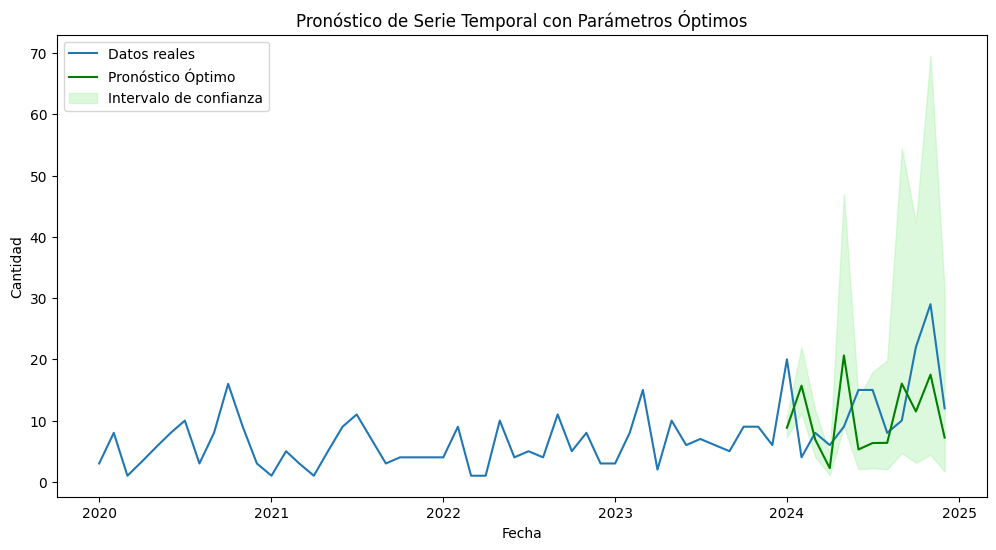

In [65]:

# Calcular el nuevo RMSE
optimal_rmse = np.sqrt(mean_squared_error(np.exp(test), optimal_forecast))
print(f"RMSE del modelo óptimo: {optimal_rmse}")

# Graficar resultados
plt.figure(figsize=(12,6))
plt.plot(base_analisis_pergolite_com.index, base_analisis_pergolite_com, label='Datos reales')
plt.plot(test.index, optimal_forecast, label='Pronóstico Óptimo', color='green')
plt.fill_between(test.index, optimal_forecast_lower, optimal_forecast_upper, 
                 color='lightgreen', alpha=0.3, label='Intervalo de confianza')
plt.title('Pronóstico de Serie Temporal con Parámetros Óptimos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.show()

RMSE del modelo óptimo: 8.87457356664262


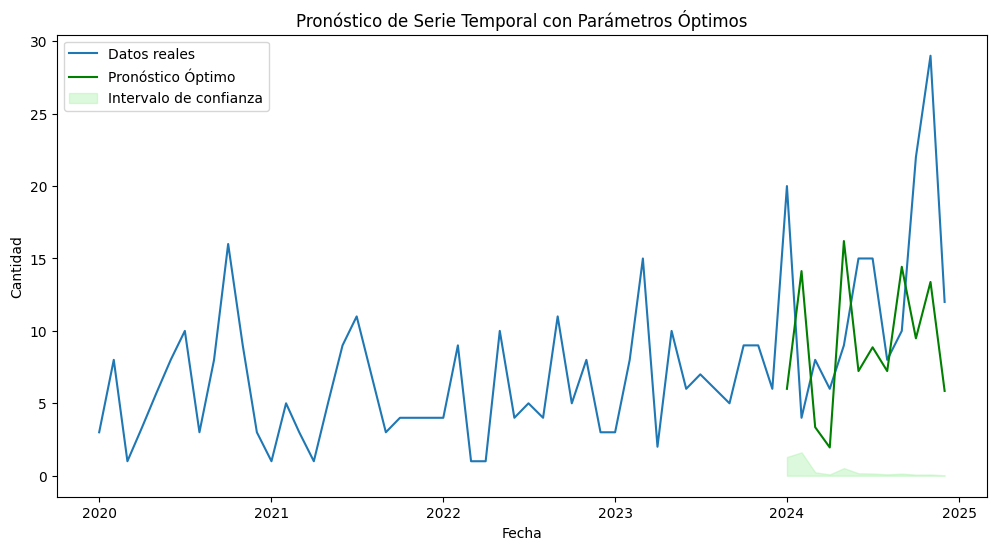

In [81]:

# Calcular el nuevo RMSE
optimal_rmse_two = np.sqrt(mean_squared_error(np.exp(test), optimal_forecast_two))
print(f"RMSE del modelo óptimo: {optimal_rmse_two}")


# Graficar resultados
plt.figure(figsize=(12,6))
plt.plot(base_analisis_pergolite_com.index, base_analisis_pergolite_com, label='Datos reales')
plt.plot(test.index, optimal_forecast_two, label='Pronóstico Óptimo', color='green')
plt.fill_between(test.index, optimal_forecast_lower_two, 
                 color='lightgreen', alpha=0.3, label='Intervalo de confianza')
plt.title('Pronóstico de Serie Temporal con Parámetros Óptimos')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.show()

print(optimal_forecast_log_two)

In [44]:
print(len(test.index))
print(len(optimal_forecast_log_two))

12


TypeError: object of type 'PredictionResultsWrapper' has no len()

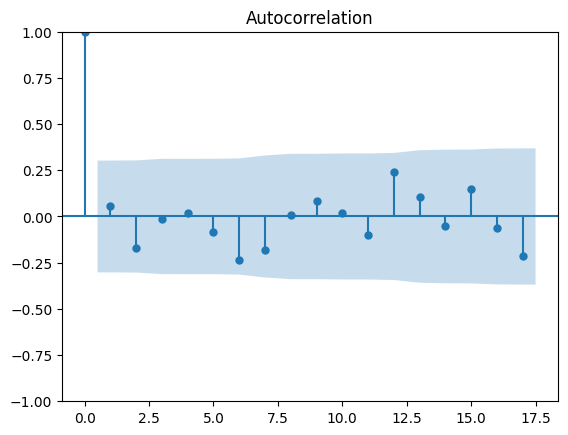

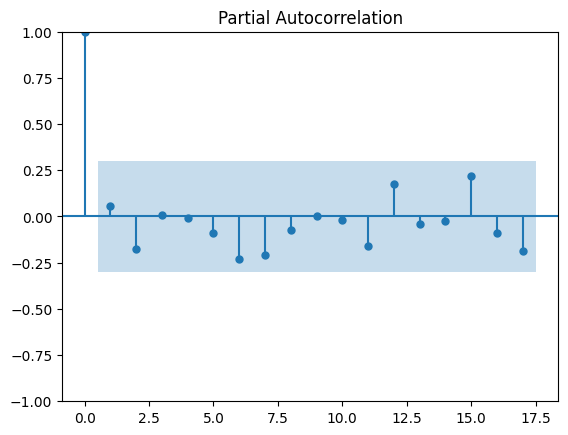

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acf_original = plot_acf(train)
pacf_original = plot_pacf(train)

In [28]:
adf_test = adfuller(train)
adf_test

(np.float64(-5.905771104919837),
 np.float64(2.7109709915982336e-07),
 0,
 41,
 {'1%': np.float64(-3.60098336718852),
  '5%': np.float64(-2.9351348158036012),
  '10%': np.float64(-2.6059629803688282)},
 np.float64(73.01488736391747))

In [35]:
#diferenciacion
print(base_analisis_pergolite_v2.index)

#base_analisis_pergolite_v2['Primera diferencia'] = base_analisis_pergolite_v2['Cantidad'] - base_analisis_pergolite_v2['Cantidad'].shift(1)

datos_diff = base_analisis_pergolite_v2.diff().dropna()



adf_result = adfuller(datos_diff)
adf_pvalue = adf_result[1]

adf_pvalue


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01',
      

np.float64(1.3324480296076912e-11)

In [9]:
adfuller(base_analisis_pergolite['Primera diferencia'].dropna())

(np.float64(-8.249221329813125),
 np.float64(5.448055862965133e-13),
 2,
 56,
 {'1%': np.float64(-3.552928203580539),
  '5%': np.float64(-2.9147306250000002),
  '10%': np.float64(-2.595137155612245)},
 np.float64(289.8665088729871))

PARTIR LA BASE

ACF Y PACF PARA LA DIFERENCIA ESTACIONAL

In [18]:
train_size= int(len(base_analisis_pergolite_v2)*0.8)
train, test = base_analisis_pergolite_v2[:train_size], base_analisis_pergolite_v2[train_size:]

print(f"Entrenamiento: {len(train)} observaciones")
print(f"Prueba: {len(test)} observaciones")



BaseA = base_analisis_pergolite[:48
                      ]
BaseB = base_analisis_pergolite[48:]
BaseA.to_excel('BaseA.xlsx')
BaseB.to_excel('BaseB.xlsx')
BaseA





Entrenamiento: 48 observaciones
Prueba: 12 observaciones


Mes
2020-01-01    1.098612
2020-02-01    2.079442
2020-03-01    0.000000
2020-04-01    1.203973
2020-05-01    1.734601
2020-06-01    2.079442
2020-07-01    2.302585
2020-08-01    1.098612
2020-09-01    2.079442
2020-10-01    2.772589
2020-11-01    2.197225
2020-12-01    1.098612
2021-01-01    0.000000
2021-02-01    1.609438
2021-03-01    1.098612
2021-04-01    0.000000
2021-05-01    1.609438
2021-06-01    2.197225
2021-07-01    2.397895
2021-08-01    1.945910
2021-09-01    1.098612
2021-10-01    1.386294
2021-11-01    1.386294
2021-12-01    1.386294
2022-01-01    1.386294
2022-02-01    2.197225
2022-03-01    0.000000
2022-04-01    0.000000
2022-05-01    2.302585
2022-06-01    1.386294
2022-07-01    1.609438
2022-08-01    1.386294
2022-09-01    2.397895
2022-10-01    1.609438
2022-11-01    2.079442
2022-12-01    1.098612
2023-01-01    1.098612
2023-02-01    2.079442
2023-03-01    2.708050
2023-04-01    0.693147
2023-05-01    2.302585
2023-06-01    1.791759
2023-07-01    1.945910
2023-08

In [39]:
BaseB

Mes
2024-01-01    2.995732
2024-02-01    1.386294
2024-03-01    2.079442
2024-04-01    1.791759
2024-05-01    2.197225
2024-06-01    2.708050
2024-07-01    2.708050
2024-08-01    2.079442
2024-09-01    2.302585
2024-10-01    3.091042
2024-11-01    3.367296
2024-12-01    2.484907
Freq: MS, Name: Cantidad, dtype: float64

COMPONENTES ACF Y PACF

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

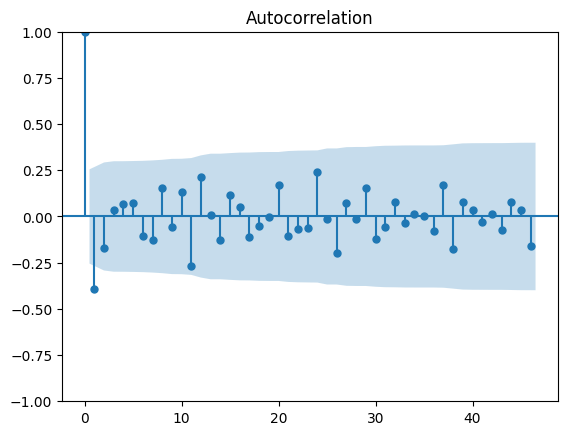

In [42]:
acf=plot_acf(datos_diff.dropna(), lags=46)





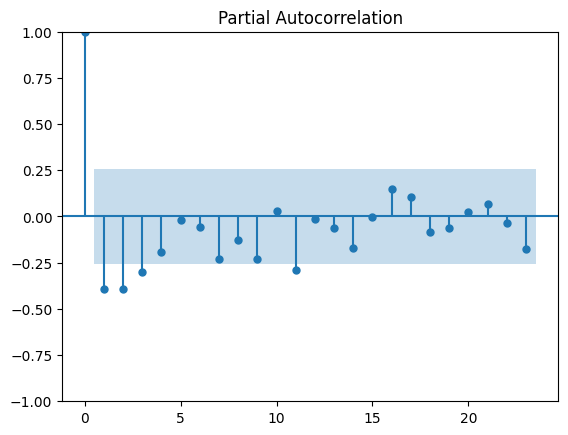

In [43]:
pacf=plot_pacf(datos_diff.dropna(), lags=23)

In [17]:
from statsmodels.tsa.stattools import arma_order_select_ic

#order_selection = arma_order_select_ic(BaseA['Primera diferencia'],ic='aic',max_ar=5,max_ma=5)

# Obtener los mejores parámetros
#best_p, best_q = order_selection.aic_min_order

#BaseA.index = pd.date_range(start='2020-01-01', periods=len(BaseA), freq='MS')
#Base_Entrenamiento=BaseA.copy()
#Base_Entrenamiento['Cantidad_normalizada']=scaler.fit_transform(Base_Entrenamiento[['Cantidad']])
modelo = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'], order=(2, 2, 0),seasonal_order=(2, 1, 2, 12),enforce_stationarity=False,
                             enforce_invertibility=False)





/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/p

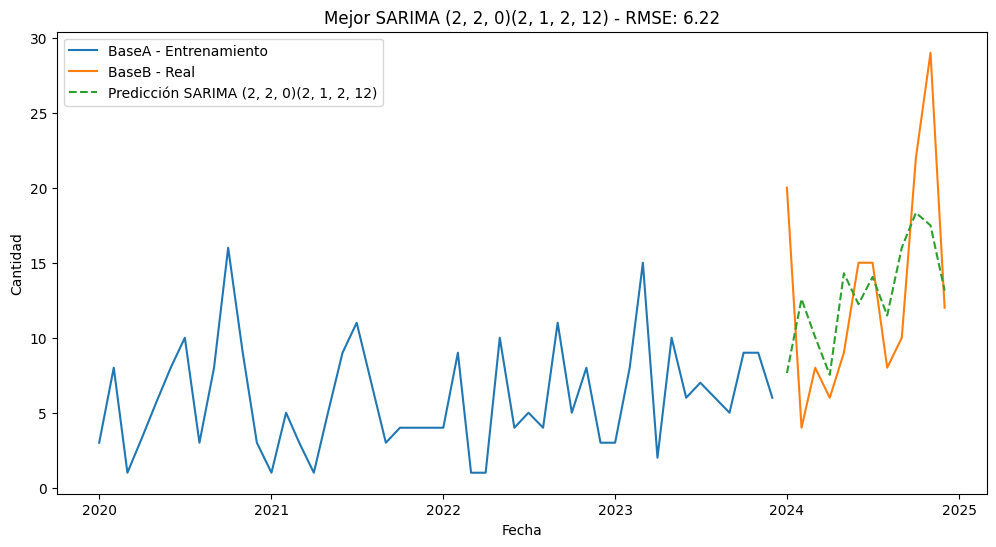

Mejores parámetros SARIMA: (2, 2, 0), Estacionales: (2, 1, 2, 12)
RMSE: 6.22


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import itertools



serie_baseA = BaseA['Cantidad']
serie_baseB = BaseB['Cantidad']

# 3. Definir rangos para la búsqueda de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 12  # estacionalidad anual

# Crear combinaciones de parámetros
param_combinations = list(itertools.product(p, d, q))
seasonal_combinations = list(itertools.product(P, D, Q))

# 4. Optimización de parámetros
resultados_sarima = []
for param in param_combinations:
    for seasonal_param in seasonal_combinations:
        seasonal_order = (seasonal_param[0], seasonal_param[1], seasonal_param[2], s)
        try:
            modelo = SARIMAX(serie_baseA, order=param, seasonal_order=seasonal_order)
            modelo_ajustado = modelo.fit(disp=False)
            predicciones = modelo_ajustado.forecast(steps=len(BaseB))
            mse = mean_squared_error(serie_baseB, predicciones)
            rmse = np.sqrt(mse)
            resultados_sarima.append((param, seasonal_order, rmse))
        except:
            continue

# 5. Seleccionar el mejor modelo
resultados_sarima_ordenados = sorted(resultados_sarima, key=lambda x: x[2])
mejor_param, mejor_seasonal, mejor_rmse = resultados_sarima_ordenados[0]

# 6. Ajustar el mejor modelo encontrado
modelo_mejor = SARIMAX(serie_baseA, order=mejor_param, seasonal_order=mejor_seasonal)
modelo_mejor_ajustado = modelo_mejor.fit()
predicciones_mejor = modelo_mejor_ajustado.forecast(steps=len(BaseB))

# 7. Graficar resultados
plt.figure(figsize=(12,6))
plt.plot(serie_baseA, label='BaseA - Entrenamiento')
plt.plot(serie_baseB, label='BaseB - Real')
plt.plot(predicciones_mejor.index, predicciones_mejor, label=f'Predicción SARIMA {mejor_param}{mejor_seasonal}', linestyle='--')
plt.legend()
plt.title(f'Mejor SARIMA {mejor_param}{mejor_seasonal} - RMSE: {mejor_rmse:.2f}')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.show()

# 8. Mostrar parámetros y RMSE
print(f"Mejores parámetros SARIMA: {mejor_param}, Estacionales: {mejor_seasonal}")
print(f"RMSE: {mejor_rmse:.2f}")


In [18]:
resultados = modelo.fit(method='powell', maxiter=600, disp=False)

/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [19]:
print(resultados.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                Cantidad   No. Observations:                   48
Model:             SARIMAX(2, 2, 0)x(2, 1, [1, 2], 12)   Log Likelihood                 -17.775
Date:                                 Sun, 23 Feb 2025   AIC                             49.551
Time:                                         16:41:09   BIC                             50.107
Sample:                                     01-01-2020   HQIC                            45.800
                                          - 12-01-2023                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7941      0.344     -2.307      0.021      -1.469      -0

<Axes: xlabel='Mes'>

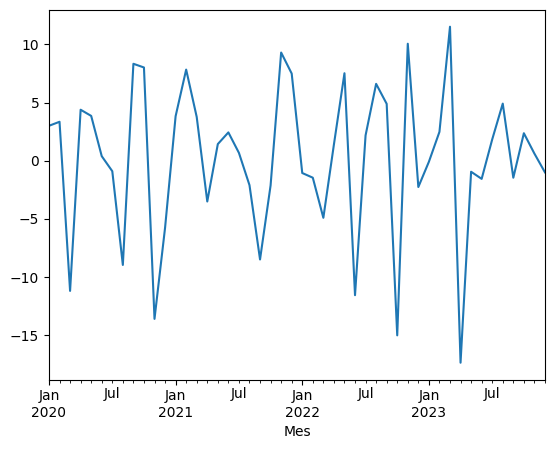

In [36]:
residuos = resultados.resid


residuos
residuos.plot()

In [37]:
from statsmodels.stats.diagnostic import het_arch

# Realiza la prueba ARCH
arch_test = het_arch(residuos)

# Resultados
print(f"Estadístico de prueba: {arch_test[0]:.4f}")
print(f"p-valor: {arch_test[1]:.4f}")

if arch_test[1] < 0.05:
    print("❌ Hay evidencia de heterocedasticidad (varianza no constante).")
else:
    print("✅ No hay evidencia de heterocedasticidad (varianza constante).")


Estadístico de prueba: 6.0598
p-valor: 0.7339
✅ No hay evidencia de heterocedasticidad (varianza constante).


/tmp/ipykernel_3093/2973395324.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  acf2.show()


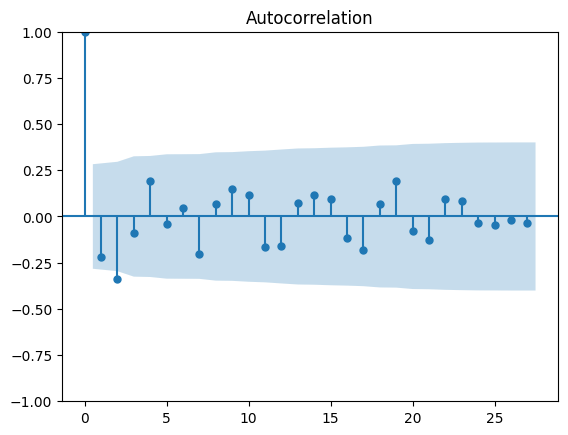

In [21]:
acf2=plot_acf(residuos, lags=27)
acf2.show()

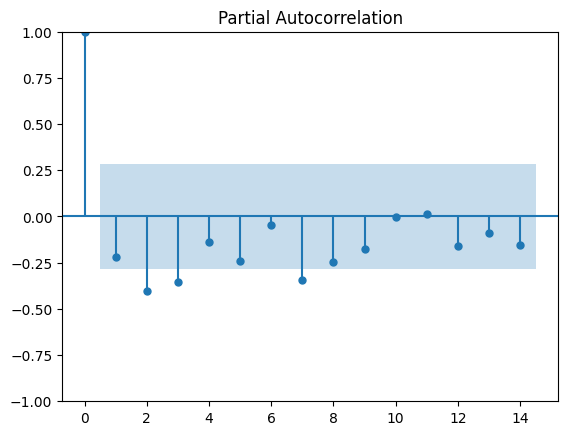

In [22]:
acf2=plot_pacf(residuos, lags=14)

In [23]:
BaseB

,Cantidad,Primera diferencia,Cantidad_diff
Mes,,,
2024-01-01,20.0,14.0,14.0
2024-02-01,4.0,-16.0,-16.0
2024-03-01,8.0,4.0,4.0
2024-04-01,6.0,-2.0,-2.0
2024-05-01,9.0,3.0,3.0
2024-06-01,15.0,6.0,6.0
2024-07-01,15.0,0.0,0.0
2024-08-01,8.0,-7.0,-7.0
2024-09-01,10.0,2.0,2.0


In [24]:
BaseA['Pronostico'] =resultados.predict()
BaseA

/tmp/ipykernel_3093/4139444989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BaseA['Pronostico'] =resultados.predict()


,Cantidad,Primera diferencia,Cantidad_diff,Pronostico
Mes,,,,
2020-01-01,3.000000,NaN,NaN,0.000000
2020-02-01,8.000000,5.000000,5.000000,4.654438
2020-03-01,1.000000,-7.000000,-7.000000,12.188836
2020-04-01,3.333333,2.333333,2.333333,-1.048014
2020-05-01,5.666667,2.333333,2.333333,1.816247
2020-06-01,8.000000,2.333333,2.333333,7.609229
2020-07-01,10.000000,2.000000,2.000000,10.902789
2020-08-01,3.000000,-7.000000,-7.000000,11.958183
2020-09-01,8.000000,5.000000,5.000000,-0.330380


<Axes: xlabel='Mes'>

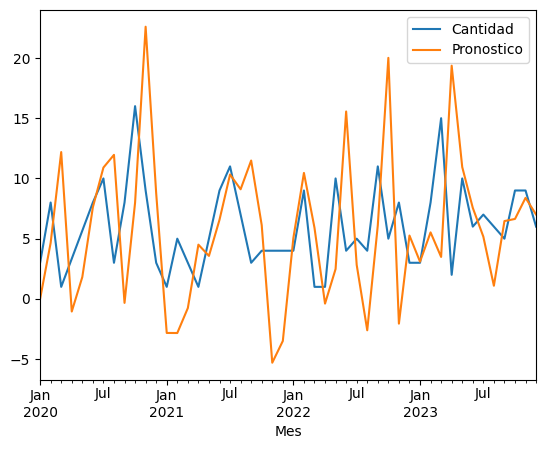

In [25]:
BaseA[['Cantidad','Pronostico']].plot()

Agregar filas con fechas futuras

In [26]:
from pandas.tseries.offsets import DateOffset

In [27]:
fechasfuturas= [BaseA.index[-1]+ DateOffset(months=x) for x in range(1,13)]

In [28]:
fechasfuturas

[Timestamp('2024-01-01 00:00:00'),
 Timestamp('2024-02-01 00:00:00'),
 Timestamp('2024-03-01 00:00:00'),
 Timestamp('2024-04-01 00:00:00'),
 Timestamp('2024-05-01 00:00:00'),
 Timestamp('2024-06-01 00:00:00'),
 Timestamp('2024-07-01 00:00:00'),
 Timestamp('2024-08-01 00:00:00'),
 Timestamp('2024-09-01 00:00:00'),
 Timestamp('2024-10-01 00:00:00'),
 Timestamp('2024-11-01 00:00:00'),
 Timestamp('2024-12-01 00:00:00')]

In [29]:
df_futura_pro =pd.DataFrame(index=fechasfuturas)
df_futura_pro


""
2024-01-01
2024-02-01
2024-03-01
2024-04-01
2024-05-01
2024-06-01
2024-07-01
2024-08-01
2024-09-01
2024-10-01


In [30]:
df_futura_pro

""
2024-01-01
2024-02-01
2024-03-01
2024-04-01
2024-05-01
2024-06-01
2024-07-01
2024-08-01
2024-09-01
2024-10-01


In [31]:
df_futura_pro = pd.DataFrame(index=fechasfuturas,columns=BaseA.columns)
df_futura_pro

#nuevabase[['Cantidad','Pronostico']].plot()

,Cantidad,Primera diferencia,Cantidad_diff,Pronostico
2024-01-01,NaN,NaN,NaN,NaN
2024-02-01,NaN,NaN,NaN,NaN
2024-03-01,NaN,NaN,NaN,NaN
2024-04-01,NaN,NaN,NaN,NaN
2024-05-01,NaN,NaN,NaN,NaN
2024-06-01,NaN,NaN,NaN,NaN
2024-07-01,NaN,NaN,NaN,NaN
2024-08-01,NaN,NaN,NaN,NaN
2024-09-01,NaN,NaN,NaN,NaN
2024-10-01,NaN,NaN,NaN,NaN


In [32]:
df_futura_pro_new=pd.concat([BaseA,df_futura_pro])
df_futura_pro_new

/tmp/ipykernel_3093/2566586945.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_futura_pro_new=pd.concat([BaseA,df_futura_pro])


,Cantidad,Primera diferencia,Cantidad_diff,Pronostico
2020-01-01,3.000000,NaN,NaN,0.000000
2020-02-01,8.000000,5.000000,5.000000,4.654438
2020-03-01,1.000000,-7.000000,-7.000000,12.188836
2020-04-01,3.333333,2.333333,2.333333,-1.048014
2020-05-01,5.666667,2.333333,2.333333,1.816247
2020-06-01,8.000000,2.333333,2.333333,7.609229
2020-07-01,10.000000,2.000000,2.000000,10.902789
2020-08-01,3.000000,-7.000000,-7.000000,11.958183
2020-09-01,8.000000,5.000000,5.000000,-0.330380
2020-10-01,16.000000,8.000000,8.000000,7.987823


In [33]:
df_futura_pro_new

,Cantidad,Primera diferencia,Cantidad_diff,Pronostico
2020-01-01,3.000000,NaN,NaN,0.000000
2020-02-01,8.000000,5.000000,5.000000,4.654438
2020-03-01,1.000000,-7.000000,-7.000000,12.188836
2020-04-01,3.333333,2.333333,2.333333,-1.048014
2020-05-01,5.666667,2.333333,2.333333,1.816247
2020-06-01,8.000000,2.333333,2.333333,7.609229
2020-07-01,10.000000,2.000000,2.000000,10.902789
2020-08-01,3.000000,-7.000000,-7.000000,11.958183
2020-09-01,8.000000,5.000000,5.000000,-0.330380
2020-10-01,16.000000,8.000000,8.000000,7.987823


In [34]:


df_futura_pro_new['Pronostico']=resultados.predict(start=48, end=59)
#df_futura_pro_new[['Cantidad','Pronostico']].plot()
df_futura_pro_new



,Cantidad,Primera diferencia,Cantidad_diff,Pronostico
2020-01-01,3.000000,NaN,NaN,NaN
2020-02-01,8.000000,5.000000,5.000000,NaN
2020-03-01,1.000000,-7.000000,-7.000000,NaN
2020-04-01,3.333333,2.333333,2.333333,NaN
2020-05-01,5.666667,2.333333,2.333333,NaN
2020-06-01,8.000000,2.333333,2.333333,NaN
2020-07-01,10.000000,2.000000,2.000000,NaN
2020-08-01,3.000000,-7.000000,-7.000000,NaN
2020-09-01,8.000000,5.000000,5.000000,NaN
2020-10-01,16.000000,8.000000,8.000000,NaN


In [35]:
df_futura_pro['Pronostico']=df_futura_pro_new['Pronostico'][48:60]
df_futura_pro_2 = df_futura_pro['Pronostico']
df_futura_pro_2
df_futura_pro_b = BaseB.merge(df_futura_pro_2,left_index=True,right_index=True)
df_futura_pro_b[['Cantidad','Pronostico']]


,Cantidad,Pronostico
Mes,,
2024-01-01,20.0,6.687232
2024-02-01,4.0,13.549700
2024-03-01,8.0,7.603773
2024-04-01,6.0,12.621431
2024-05-01,9.0,20.962817
2024-06-01,15.0,23.157795
2024-07-01,15.0,27.312848
2024-08-01,8.0,26.521029
2024-09-01,10.0,32.223400


RMSE


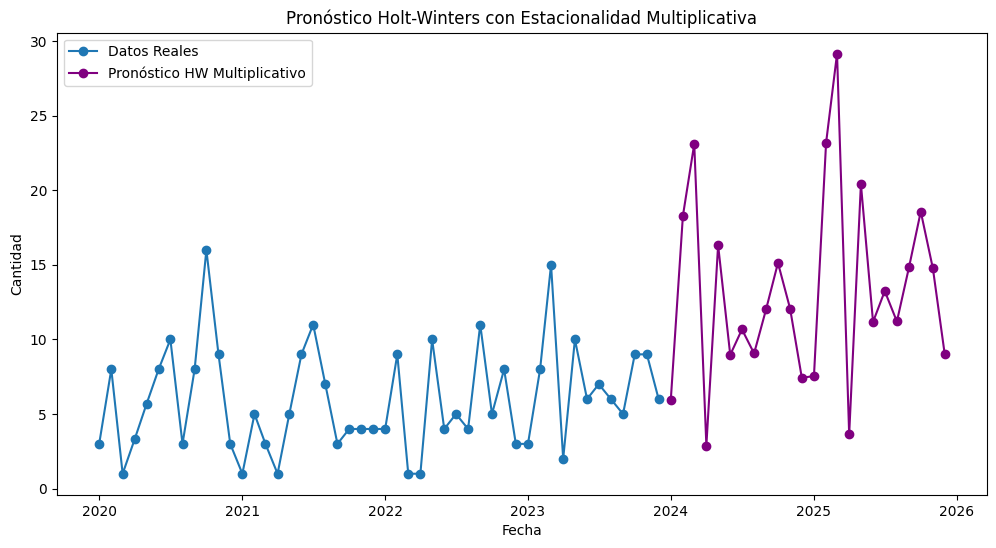

2024-01-01     5.923192
2024-02-01    18.279284
2024-03-01    23.096554
2024-04-01     2.889514
2024-05-01    16.317519
2024-06-01     8.966972
2024-07-01    10.671017
2024-08-01     9.061481
2024-09-01    12.053447
2024-10-01    15.128354
2024-11-01    12.066014
2024-12-01     7.428527
2025-01-01     7.545507
2025-02-01    23.174114
2025-03-01    29.146352
2025-04-01     3.630211
2025-05-01    20.412863
2025-06-01    11.171384
2025-07-01    13.241682
2025-08-01    11.201446
2025-09-01    14.845057
2025-10-01    18.565778
2025-11-01    14.756674
2025-12-01     9.054829
Freq: MS, dtype: float64

In [287]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt

# Holt-Winters con estacionalidad multiplicativa
hw_model_mul = ExponentialSmoothing(BaseA['Cantidad'],
                                    trend='add',
                                    seasonal='mul',
                                    seasonal_periods=12).fit(smoothing_level=0.6,
                                                             smoothing_trend=0.1,
                                                             smoothing_seasonal=0.5)

# Pronóstico
hw_forecast_mul = hw_model_mul.forecast(24)

# Graficar
plt.figure(figsize=(12,6))
plt.plot(BaseA.index, BaseA['Cantidad'], label='Datos Reales', marker='o')
plt.plot(hw_forecast_mul.index, hw_forecast_mul, label='Pronóstico HW Multiplicativo', marker='o', color='purple')
plt.title('Pronóstico Holt-Winters con Estacionalidad Multiplicativa')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')
plt.legend()
plt.show()
hw_forecast_mul


12:31:51 - cmdstanpy - INFO - Chain [1] start processing
12:31:52 - cmdstanpy - INFO - Chain [1] done processing
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/prophet/forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


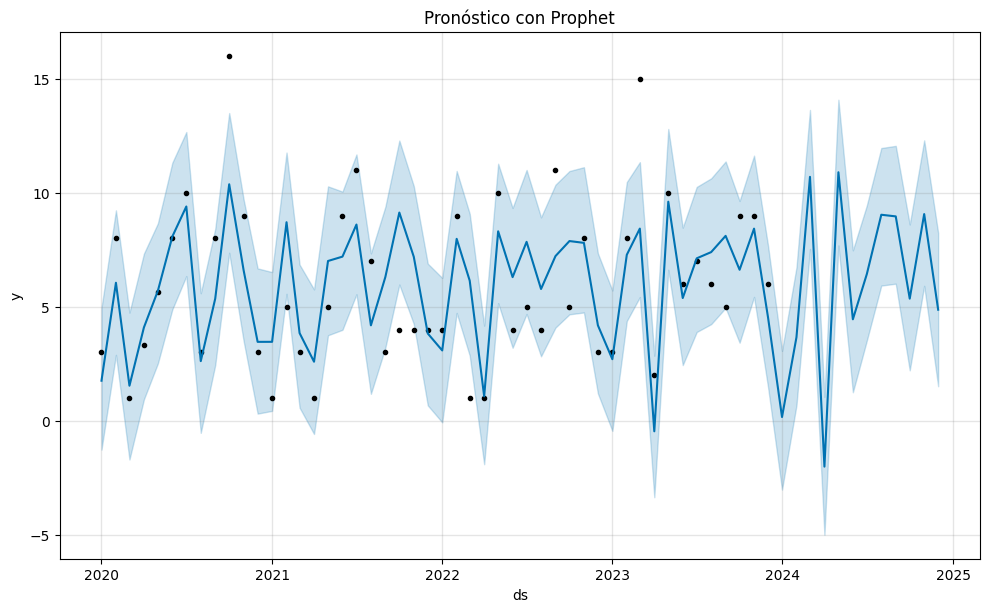

MSE (Prophet): 8.69
MAE (Prophet): 2.53


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,4.906800,-1.258377,4.953065,4.906800,4.906800,-3.144859,-3.144859,-3.144859,-3.144859,-3.144859,-3.144859,0.0,0.0,0.0,1.761941
1,2020-02-01,4.918563,2.895271,9.231364,4.918563,4.918563,1.137663,1.137663,1.137663,1.137663,1.137663,1.137663,0.0,0.0,0.0,6.056226
2,2020-03-01,4.929568,-1.692666,4.747448,4.929568,4.929568,-3.387515,-3.387515,-3.387515,-3.387515,-3.387515,-3.387515,0.0,0.0,0.0,1.542053
3,2020-04-01,4.941331,0.944252,7.331714,4.941331,4.941331,-0.845977,-0.845977,-0.845977,-0.845977,-0.845977,-0.845977,0.0,0.0,0.0,4.095354
4,2020-05-01,4.952715,2.522413,8.663315,4.952715,4.952715,0.751539,0.751539,0.751539,0.751539,0.751539,0.751539,0.0,0.0,0.0,5.704254
5,2020-06-01,4.964478,4.889267,11.320259,4.964478,4.964478,3.117424,3.117424,3.117424,3.117424,3.117424,3.117424,0.0,0.0,0.0,8.081903
6,2020-07-01,4.975862,6.347513,12.664311,4.975862,4.975862,4.423905,4.423905,4.423905,4.423905,4.423905,4.423905,0.0,0.0,0.0,9.399767
7,2020-08-01,4.987626,-0.524237,5.596676,4.987626,4.987626,-2.366438,-2.366438,-2.366438,-2.366438,-2.366438,-2.366438,0.0,0.0,0.0,2.621187
8,2020-09-01,4.999389,2.445849,8.414713,4.999389,4.999389,0.359421,0.359421,0.359421,0.359421,0.359421,0.359421,0.0,0.0,0.0,5.358810
9,2020-10-01,5.010773,7.371254,13.496851,5.010773,5.010773,5.362662,5.362662,5.362662,5.362662,5.362662,5.362662,0.0,0.0,0.0,10.373435


In [286]:
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Preparar datos para Prophet
BaseA_reset = BaseA.reset_index().rename(columns={'Mes': 'ds', 'Cantidad': 'y'})

# Iniciar modelo Prophet
prophet_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)

# Ajustar modelo
prophet_model.fit(BaseA_reset)

# Crear DataFrame para pronóstico
future = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast = prophet_model.predict(future)

# Graficar pronóstico
fig = prophet_model.plot(forecast)
plt.title('Pronóstico con Prophet')
plt.show()

# Evaluar métricas básicas
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Comparar con últimos 12 meses
actuals = BaseA_reset['y'][-12:].values
preds = forecast['yhat'][-12:].values

mse = mean_squared_error(actuals, preds)
mae = mean_absolute_error(actuals, preds)

print(f"MSE (Prophet): {mse:.2f}")
print(f"MAE (Prophet): {mae:.2f}")

forecast


DatetimeIndex(['2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01'],
              dtype='datetime64[ns]', freq='MS')


c:\Users\JORGE CONTRERAS\proyecto_pronosticoV2\proyecto_damisV1\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\JORGE CONTRERAS\AppData\Local\Temp\ipykernel_21272\3497080206.py:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1),


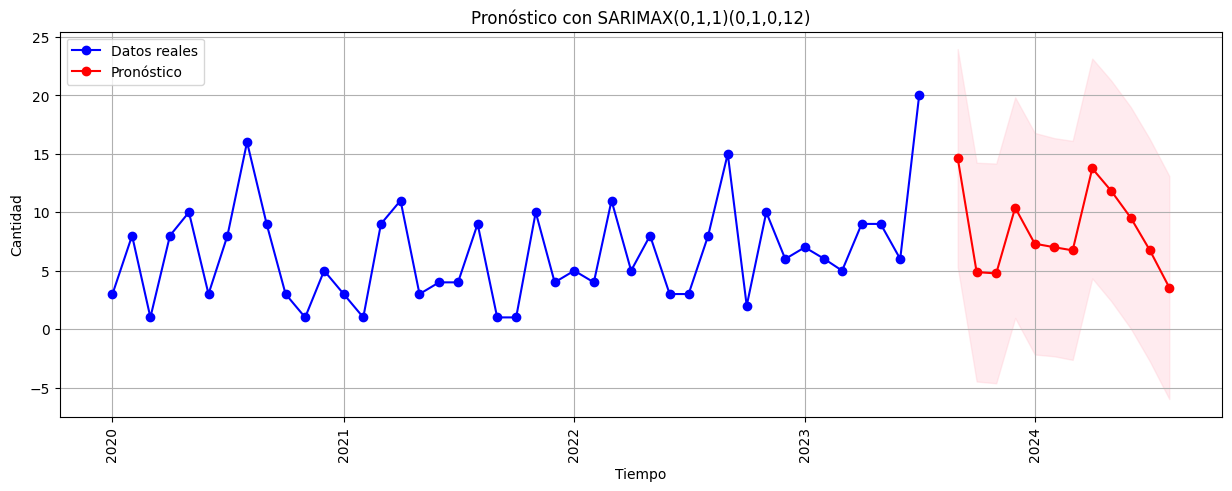

        Fecha  Pronóstico  Límite Inferior  Límite Superior
0  2023-08-31   14.639448         5.319654        23.959242
1  2023-09-30    4.876625        -4.482787        14.236037
2  2023-10-31    4.765071        -4.633782        14.163923
3  2023-11-30   10.389289         0.951161        19.827417
4  2023-12-31    7.306823        -2.170442        16.784089
5  2024-01-31    7.004959        -2.328284        16.338201
6  2024-02-29    6.736650        -2.631734        16.105035
7  2024-03-31   13.744630         4.341230        23.148030
8  2024-04-30   11.828884         2.390581        21.267187
9  2024-05-31    9.523561         0.050484        18.996638
10 2024-06-30    6.764045        -2.743678        16.271769
11 2024-07-31    3.552392        -5.989863        13.094646


In [84]:
print(BaseA.index)


# 1️⃣ Crear el modelo SARIMAX
modelo_final = sm.tsa.statespace.SARIMAX(BaseA['Cantidad'],
                                         order=(best_p,1,best_q), 
                                         seasonal_order=(1,1,1,12),
                                         enforce_stationarity=False,
                                         enforce_invertibility=False)

resultado = modelo_final.fit()

# 2️⃣ Hacer predicciones para los próximos 12 meses
periodos_prediccion = 12
predicciones = resultado.get_forecast(steps=periodos_prediccion)
intervalo_confianza = predicciones.conf_int()

# 3️⃣ Generar las fechas futuras para el eje X
BaseA.index = pd.to_datetime(BaseA.index, format='%b-%y')

if pd.isnull(BaseA.index[-1]):
    print("Error: Última fecha en BaseA no es válida")
else:
    fechas_futuras = pd.date_range(start=BaseA.index[-1] + pd.DateOffset(months=1), 
                                   periods=periodos_prediccion, freq='M')

# 4️⃣ Graficar los resultados
plt.figure(figsize=(15,5))
plt.plot(BaseA.index, BaseA['Cantidad'], label='Datos reales', color='blue', marker='o')
plt.plot(fechas_futuras, predicciones.predicted_mean, label='Pronóstico', color='red', marker='o')

# 5️⃣ Agregar etiquetas de valores en los puntos de pronóstico
# Asegurar que predicciones tengan las fechas correctas
predicciones_df = pd.DataFrame({'Prediccion': predicciones.predicted_mean}, index=fechas_futuras)

for i, (fecha, txt) in enumerate(predicciones_df.itertuples()):
    plt.annotate(f"{txt:.1f}", (fecha, txt), 
                 textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='red')


# 6️⃣ Agregar banda de intervalo de confianza
plt.fill_between(fechas_futuras, 
                 intervalo_confianza.iloc[:, 0], 
                 intervalo_confianza.iloc[:, 1], 
                 color='pink', alpha=0.3)

# 7️⃣ Personalizar la visualización
plt.xticks(rotation=90)  # Rotar etiquetas del eje X
plt.xlabel('Tiempo')
plt.ylabel('Cantidad')
plt.title('Pronóstico con SARIMAX(0,1,1)(0,1,0,12)')
plt.legend()
plt.grid()

# 8️⃣ Mostrar la gráfica
plt.show()

tabla_pronostico = pd.DataFrame({
    'Fecha': fechas_futuras,  # Fechas futuras
    'Pronóstico': predicciones.predicted_mean.values,  # Valores pronosticados
    'Límite Inferior': intervalo_confianza.iloc[:, 0].values,  # Intervalo inferior
    'Límite Superior': intervalo_confianza.iloc[:, 1].values   # Intervalo superior
})

# Mostrar la tabla en pantalla
print(tabla_pronostico)

# Opcional: Guardar la tabla en un archivo CSV
tabla_pronostico.to_excel('pro.xlsx', index=False)


In [32]:
base_analisis_hot.to_excel('base.xlsx')

HOT WINTERS

In [262]:
train =BaseA[:43]
test_a= BaseB[28:]
BaseB


,Cantidad,Primera diferencia,Segunda diferencia,Diferencia Estacionalidad,Primera Diferencia Estacionalidad
Mes,,,,,
Feb-24,4,-16.0,-30.0,-4.0,-21.0
Mar-24,8,4.0,20.0,-7.0,-3.0
Apr-24,6,-2.0,-6.0,4.0,11.0
May-24,9,3.0,5.0,-1.0,-5.0
Jun-24,15,6.0,3.0,9.0,10.0
Jul-24,15,0.0,-6.0,8.0,-1.0
Aug-24,8,-7.0,-7.0,2.0,-6.0
Sep-24,10,2.0,9.0,5.0,3.0
Oct-24,22,12.0,10.0,13.0,8.0


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


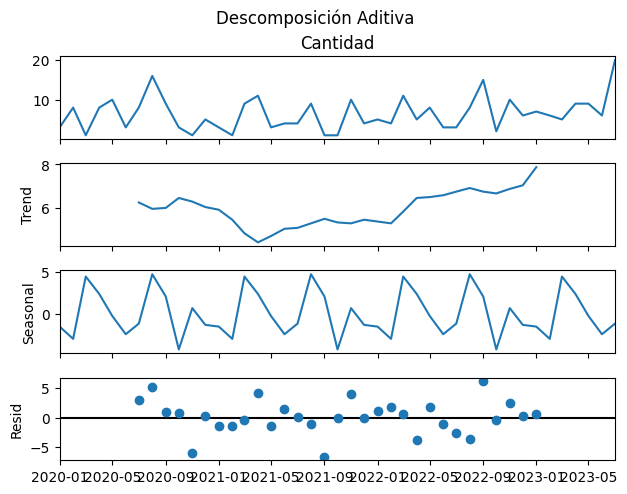

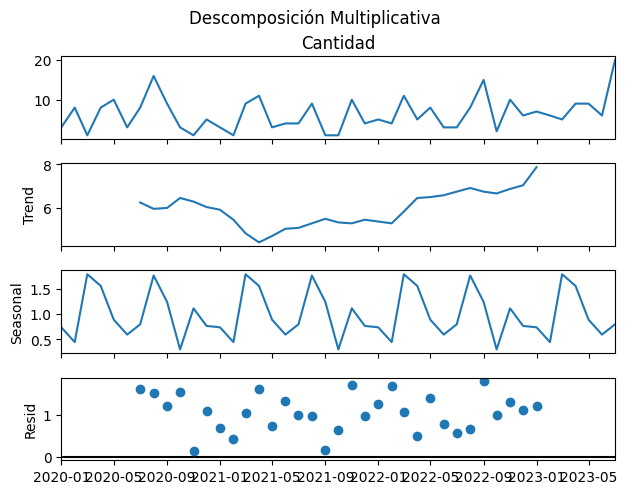

In [263]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
# Suponiendo que tu data es mensual con posible estacionalidad de 12 meses
model = ExponentialSmoothing(
    BaseA['Cantidad'], 
    trend='mul',          # tendencia aditiva
    seasonal='mul',       # estacionalidad aditiva
    seasonal_periods=12   # 12 meses
)
fit = model.fit()

n_test = len(BaseB['Cantidad'])
hw_forecast = fit.forecast(steps=n_test)
hw_forecast

# 1. Descomposición aditiva
result_add = seasonal_decompose(BaseA['Cantidad'], model='additive', period=12)
fig_add = result_add.plot()
fig_add.suptitle('Descomposición Aditiva', y=1.02)
plt.show()

# 2. Descomposición multiplicativa
result_mul = seasonal_decompose(BaseA['Cantidad'], model='multiplicative', period=12)
fig_mul = result_mul.plot()
fig_mul.suptitle('Descomposición Multiplicativa', y=1.02)
plt.show()





In [264]:
df_comparation = pd.DataFrame({
    'Real': BaseB['Cantidad'],
    'Pronostico': hw_forecast
})


df_comparation

,Real,Pronostico
2023-08-01 00:00:00,NaN,21.496216
2023-09-01 00:00:00,NaN,17.898862
2023-10-01 00:00:00,NaN,1.259126
2023-11-01 00:00:00,NaN,11.110606
2023-12-01 00:00:00,NaN,9.082242
2024-01-01 00:00:00,NaN,5.944675
2024-02-01 00:00:00,NaN,8.344795
2024-03-01 00:00:00,NaN,10.157290
2024-04-01 00:00:00,NaN,15.441902
2024-05-01 00:00:00,NaN,14.739205


In [265]:
print(fit.summary())


                       ExponentialSmoothing Model Results                       
Dep. Variable:                 Cantidad   No. Observations:                   43
Model:             ExponentialSmoothing   SSE                            474.292
Optimized:                         True   AIC                            135.227
Trend:                   Multiplicative   BIC                            163.406
Seasonal:                Multiplicative   AICC                           163.727
Seasonal Periods:                    12   Date:                 Fri, 21 Feb 2025
Box-Cox:                          False   Time:                         10:58:29
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0928749                alpha                 True
smoothing_trend          

In [145]:
predictions = fit.forecast(steps=len(test))


/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/serway_85/proyecto_pronstico/pronostico_damis/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [147]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(BaseB['Cantidad'], predictions)
mse = mean_squared_error(BaseB['Cantidad'], predictions)
rmse = mse**0.5

print("MAE:", mae)
print("RMSE:", rmse)


MAE: 6.7500452659142
RMSE: 8.877706057712343
